In [1]:
import pandas as pd
from functools import reduce
import math
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as md

In [2]:
# import of adj_mat
# import of nodes_cluster
# import of news_data
# import of crypto_data

# Import section

## adj_mat

In [3]:
adj_mat = pd.read_csv('../Griffin_data/Adjacency_Matrix_Output.csv') #, index_col='Unnamed: 0'
adj_mat = adj_mat[['src', 'dst', 'date', 'cluster_src', 'neighbours', 'neighbours_cluster', 'neighbours_!cluster', 'cluster_dst']]
adj_mat


,src,dst,date,cluster_src,neighbours,neighbours_cluster,neighbours_!cluster,cluster_dst
0,tbwhale_,greatbuy2012,2021-10-24,C7,2,2,0,C7
1,leerzeit,terry_twatter,2021-10-24,C7,183,173,10,C7
2,leerzeit,neptune_xrp,2021-10-24,C7,183,173,10,C7
3,twitsforbrains1,ivo_psd,2021-10-24,C7,3,3,0,C7
4,garygensler,moonboyp,2021-10-24,C7,28,27,1,C7
...,...,...,...,...,...,...,...,...
215631,sol_kusanagi,dan_lisf1227,2021-12-26,C5,6,6,0,C5
215632,dmsbigwin,dogevillage_bsc,2021-12-26,C7,2,2,0,C7
215633,sol_lanas,[twitter_query=sol],2021-12-26,C7,2,2,0,C7
215634,bella2021hell,[twitter_query=sol],2021-12-26,C7,3,2,1,C7


## nodes_cluster

## news_data

## crypto_data

In [4]:
import yfinance as yf
import os
import pandas as pd
import numpy as np
from yahoofinancials import YahooFinancials
#input value, data from yahoo finance
value = input("Please enter the currency: \n")
ticker = yf.Ticker(f'{value}-USD')
df_ta = ticker.history(period="5y")
df_ta.drop(['Open', 'High', 'Low', 'Dividends', 'Stock Splits'], axis=1, inplace=True)
#add index value
p = df_ta.index.values
df_ta.insert( 0, column="Date",value = p)
#Calculate RSI
delta = df_ta['Close'].diff(1) #difference from the previous day
delta = delta.dropna()
#get the positive gains(up) and negative gains(down)
up = delta.copy()
down = delta.copy()
up[up < 0] = 0
down[down > 0] = 0
#Get the time period 14 days
period = 14
#calculate the average gain and loss
AVG_Gain = up.rolling(window=period).mean()
AVG_Loss = abs(down.rolling(window=period).mean())
#Calculate RSI
RS = AVG_Gain / AVG_Loss #relative strength
#RSI
RSI = 100.0 - (100.0/(1.0 + RS))
#Put it all together
new_df = pd.DataFrame()
new_df['Close'] = df_ta['Close']
new_df['RSI'] = RSI
new_df
#Get Buy and Sell Signals
conditions = [
    (new_df['RSI'] < 80) & (new_df['RSI'] > 20),
    (new_df['RSI'] < 80),
    (new_df['RSI'] > 20)]
choices = [0, -2, 2]
df_ta['signal_rsi'] = np.select(conditions, choices, default='0')
#Bollinger Bands indicator
period= 20
#Simple Moving Average
df_ta['SMA'] = df_ta['Close'].rolling(window=period).mean()
#Standard deviation
df_ta['STD'] = df_ta['Close'].rolling(window=period).std()
#upper band
df_ta['Upper'] = df_ta['SMA'] + (df_ta['STD']*2)
#lower band
df_ta['Lower'] = df_ta['SMA'] - (df_ta['STD']*2)
#Create Signal Value
conditions = [
    (df_ta.Lower > df_ta.Close) & (df_ta.Upper < df_ta.Close),
    (df_ta.Lower > df_ta.Close),
    (df_ta.Upper < df_ta.Close)]
choices = [0, 2, -2]
df_ta['signal_bb'] = np.select(conditions, choices, default='0')
df_ta = df_ta.dropna()
#On Balance Volume indicator
df_ta['Daily Returns'] = df_ta['Close'].pct_change()
df_ta['signal_obv'] = 0
df_ta.loc[df_ta['Daily Returns'] > 0, 'signal_obv'] = 2
df_ta.loc[df_ta['Daily Returns'] < 0, 'signal_obv'] = -2
df_ta.dropna(inplace= True)
#MVA indicator
#Create the simple MVA
def SMA(data, period = 30, column ='Close'):
    return data[column].rolling(window=period).mean()
#Creating the Exponential MVA
def EMA(data, period=20, column='Close'):
    return data[column].ewm(span=period, adjust=False).mean()
#Calculate MVA Convergence/Divergence
def MACD(data, period_long=28, period_short=12, period_signal=9, column='Close'):
    #calculate the short term exponential MVA
    ShortEMA = EMA(data, period_short, column=column)
    #calculate the long term exponential MVA
    LongEMA = EMA(data, period_long, column=column)
    #calculate the MVA Convergence/Divergence MACD
    data['MACDA'] = ShortEMA - LongEMA
    #calculate the signal line
    data['Signal_Line'] = EMA(data, period_signal, column='MACD')
    return data
df_ta['SMA'] = SMA(df_ta)
df_ta['EMA'] = EMA(df_ta)
#Create a Simple Moving Average indicator
def SMA(data, period = 30, column = 'Close'):
    return data[column].rolling(window=period).mean()
#Create two new columns to store 20 and 50 day SMA
df_ta['SMA20']=SMA(df_ta, 20)
df_ta['SMA50']=SMA(df_ta, 50)
#Get Buy and Sell Signals
df_ta['signal_mva'] = np.where(df_ta['SMA20']> df_ta['SMA50'], 2, -2)
# Delete redundant data
df_ta.drop(['SMA', 'STD', 'Upper', 'Lower','Daily Returns', 'EMA','SMA20','SMA50'], axis=1, inplace=True)
#prepare datatype
df_ta['signal_rsi'] = df_ta['signal_rsi'].astype('int')
df_ta['signal_bb'] = df_ta['signal_bb'].astype('int')
df_ta['signal_mva'] = df_ta['signal_mva'].astype('int')
df_ta['signal_obv'] = df_ta['signal_obv'].astype('int')
#add calculated average
zaehler =  df_ta.apply(lambda x: (0.3 * x['signal_bb']) + (0.3 * x['signal_mva']) + (0.2 * x['signal_obv']) +(0.2 * x['signal_rsi']), axis=1)
df_ta['calculated_average'] = zaehler / 1
#Plot Frame
df_ta

Please enter the currency: 
BTC


,Date,Close,Volume,signal_rsi,signal_bb,signal_obv,signal_mva,calculated_average
Date,,,,,,,,
2017-02-13,2017-02-13,990.642029,100607000,0,0,-2,-2,-1.0
2017-02-14,2017-02-14,1004.549988,137946000,0,0,2,-2,-0.2
2017-02-15,2017-02-15,1007.479980,89759400,0,0,2,-2,-0.2
2017-02-16,2017-02-16,1027.439941,122277000,0,0,2,-2,-0.2
2017-02-17,2017-02-17,1046.209961,136474000,0,0,2,-2,-0.2
...,...,...,...,...,...,...,...,...
2022-01-20,2022-01-20,40680.417969,20382033940,0,0,-2,-2,-1.0
2022-01-21,2022-01-21,36457.316406,43011992031,0,2,-2,-2,-0.4
2022-01-22,2022-01-22,35030.250000,39714385405,0,2,-2,-2,-0.4


# Merging section (probably needed)

# Model definition (probably needed)

## max. cluster strength

In [5]:
# cluster strength

#matrix input: src, dst, cluster_dst

## input:
### date
### cluster annotation per node, per day
## throughput1:
### number of neighbors inside cluster per node, per day
### number of total neighbors per node, per day (degree per node, per day)
## throughput2:
### (number of neighbors inside cluster per node, per day) / (degree per node, per day)
#### neighbours_cluster / neighbours
## output:
### lowest value of throughput2, per day

In [6]:
adj_mat['cluster_strength'] = adj_mat['neighbours_cluster'] / adj_mat['neighbours']
adj_mat['date'] = pd.to_datetime(adj_mat['date'])


#adj_mat_grouped = adj_mat.groupby([pd.Grouper(key='date', freq='D'),'cluster_src']).min()

adj_mat




,src,dst,date,cluster_src,neighbours,neighbours_cluster,neighbours_!cluster,cluster_dst,cluster_strength
0,tbwhale_,greatbuy2012,2021-10-24,C7,2,2,0,C7,1.000000
1,leerzeit,terry_twatter,2021-10-24,C7,183,173,10,C7,0.945355
2,leerzeit,neptune_xrp,2021-10-24,C7,183,173,10,C7,0.945355
3,twitsforbrains1,ivo_psd,2021-10-24,C7,3,3,0,C7,1.000000
4,garygensler,moonboyp,2021-10-24,C7,28,27,1,C7,0.964286
...,...,...,...,...,...,...,...,...,...
215631,sol_kusanagi,dan_lisf1227,2021-12-26,C5,6,6,0,C5,1.000000
215632,dmsbigwin,dogevillage_bsc,2021-12-26,C7,2,2,0,C7,1.000000
215633,sol_lanas,[twitter_query=sol],2021-12-26,C7,2,2,0,C7,1.000000
215634,bella2021hell,[twitter_query=sol],2021-12-26,C7,3,2,1,C7,0.666667


array([[<AxesSubplot:title={'center':'cluster_strength'}>]], dtype=object)

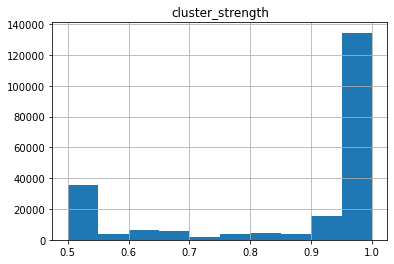

In [7]:
#plots
adj_mat[['cluster_strength']].hist('cluster_strength')

In [8]:
cs_day = adj_mat.groupby(['date'])['cluster_strength'].min()
cs_day = cs_day.to_frame()
cs_day

,cluster_strength
date,
2021-10-24,0.5
2021-10-25,0.5
2021-10-26,0.5
2021-10-27,0.5
2021-10-28,0.5
...,...
2021-12-22,0.5
2021-12-23,0.5
2021-12-24,0.5


array([[<AxesSubplot:title={'center':'cluster_strength'}>]], dtype=object)

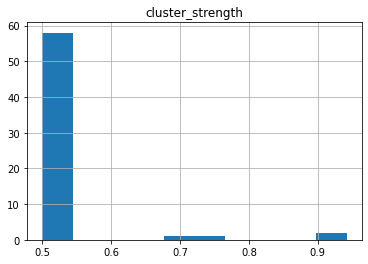

In [9]:
cs_day['cluster_strength'].unique()
cs_day.hist('cluster_strength')


For the scores it is important to note that the lowest value indicates that there is no stimulation for a shock reaction.
In the model n = -1 means that there is the lowest possible amount of stimulation from the daily news sentiment whereas n = 1 means that there is the highest possible amount. 

## sentiment score

In [10]:
news_df = pd.read_excel('../GPT-3_Approach/output_data_sentiment.xlsx', index_col='Unnamed: 0').drop(columns=['Unnamed: 0.1','Unnamed: 0.1.1'])

In [11]:
news_df.head(3)

,author,title,description,url,urlToImage,publishedAt,content,source.id,source.name,Query,merge,sentiment,topic,sentiment_bin,date
0,Richard Lawler,A fake press release claiming Kroger accepts c...,A crypto hoax claimed Kroger is accepting Bitc...,https://www.theverge.com/2021/11/5/22765098/kr...,https://cdn.vox-cdn.com/thumbor/CKp0YjnwF88--m...,2021-11-05 13:32:14,A similar hoax earlier this year tied Walmart ...,the-verge,The Verge,bitcoin,A fake press release claiming Kroger accepts c...,Negative,NaN,0.0,2021-11-05
1,mfox@businessinsider.com (Matthew Fox),An ethereum futures ETF will be available befo...,"""Though a spot Bitcoin ETF is possible in 2022...",https://markets.businessinsider.com/news/curre...,https://images2.markets.businessinsider.com/61...,2021-11-06 12:15:00,Ether.\nNurPhoto\n<ul><li>The approval of a bi...,business-insider,Business Insider,bitcoin,An ethereum futures ETF will be available befo...,Neutral,NaN,-1.0,2021-11-06
2,Entrepreneur Staff,Bitcoin Trades 7% Higher,Bitcoin was trading over 7% higher on Monday m...,https://www.entrepreneur.com/article/395938,https://assets.entrepreneur.com/content/3x2/20...,2021-11-08 16:07:45,Bitcoin was trading over 7% higher on Monday m...,NaN,Entrepreneur,bitcoin,Bitcoin Trades 7% Higher; Bitcoin was trading ...,Positive,NaN,0.0,2021-11-08


## indicator score

In [12]:
df_ta = df_ta.loc['2021-10-21':'2021-12-31']
df_ta

,Date,Close,Volume,signal_rsi,signal_bb,signal_obv,signal_mva,calculated_average
Date,,,,,,,,
2021-10-21,2021-10-21,62210.171875,45908121370,0,0,-2,2,0.2
2021-10-22,2021-10-22,60692.265625,38434082775,0,0,-2,2,0.2
2021-10-23,2021-10-23,61393.617188,26882546034,0,0,2,2,1.0
2021-10-24,2021-10-24,60930.835938,27316183882,0,0,-2,2,0.2
2021-10-25,2021-10-25,63039.824219,31064911614,0,0,2,2,1.0
...,...,...,...,...,...,...,...,...
2021-12-27,2021-12-27,50640.417969,24324345758,0,0,-2,-2,-1.0
2021-12-28,2021-12-28,47588.855469,33430376883,0,0,-2,-2,-1.0
2021-12-29,2021-12-29,46444.710938,30049226299,0,0,-2,-2,-1.0


In [13]:
df_ta.describe()

,Close,Volume,signal_rsi,signal_bb,signal_obv,signal_mva,calculated_average
count,72.000000,7.200000e+01,72.0,72.000000,72.000000,72.000000,72.000000
mean,55819.096300,3.340240e+10,0.0,0.027778,-0.222222,0.055556,-0.019444
std,6487.504301,7.198025e+09,0.0,0.530007,2.001564,2.013258,0.688873
min,46202.144531,1.903065e+10,0.0,-2.000000,-2.000000,-2.000000,-1.000000
25%,49367.262695,2.819713e+10,0.0,0.000000,-2.000000,-2.000000,-0.400000
50%,57117.626953,3.249791e+10,0.0,0.000000,-2.000000,2.000000,0.200000
75%,61337.622070,3.703018e+10,0.0,0.000000,2.000000,2.000000,0.200000
max,67566.828125,6.138568e+10,0.0,2.000000,2.000000,2.000000,1.000000


array([[<AxesSubplot:title={'center':'calculated_average'}>]],
      dtype=object)

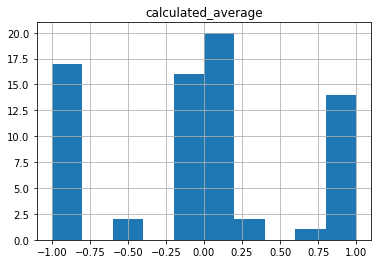

In [14]:
df_ta.hist('calculated_average')

## Processing of dataframe

In [15]:
df_ta.rename(columns={'Date':'date'}, inplace=True)

D:\anaconda3\lib\site-packages\pandas\core\frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [16]:
news_df

,author,title,description,url,urlToImage,publishedAt,content,source.id,source.name,Query,merge,sentiment,topic,sentiment_bin,date
0,Richard Lawler,A fake press release claiming Kroger accepts c...,A crypto hoax claimed Kroger is accepting Bitc...,https://www.theverge.com/2021/11/5/22765098/kr...,https://cdn.vox-cdn.com/thumbor/CKp0YjnwF88--m...,2021-11-05 13:32:14,A similar hoax earlier this year tied Walmart ...,the-verge,The Verge,bitcoin,A fake press release claiming Kroger accepts c...,Negative,NaN,0.0,2021-11-05
1,mfox@businessinsider.com (Matthew Fox),An ethereum futures ETF will be available befo...,"""Though a spot Bitcoin ETF is possible in 2022...",https://markets.businessinsider.com/news/curre...,https://images2.markets.businessinsider.com/61...,2021-11-06 12:15:00,Ether.\nNurPhoto\n<ul><li>The approval of a bi...,business-insider,Business Insider,bitcoin,An ethereum futures ETF will be available befo...,Neutral,NaN,-1.0,2021-11-06
2,Entrepreneur Staff,Bitcoin Trades 7% Higher,Bitcoin was trading over 7% higher on Monday m...,https://www.entrepreneur.com/article/395938,https://assets.entrepreneur.com/content/3x2/20...,2021-11-08 16:07:45,Bitcoin was trading over 7% higher on Monday m...,NaN,Entrepreneur,bitcoin,Bitcoin Trades 7% Higher; Bitcoin was trading ...,Positive,NaN,0.0,2021-11-08
3,NaN,Bitcoin hits new record as crypto market cap e...,Bitcoin and ether made record peaks in the Asi...,https://www.reuters.com/technology/bitcoin-hit...,https://www.reuters.com/resizer/InHvCiSZm4U-VU...,2021-11-08 23:38:00,A representation of the virtual cryptocurrency...,reuters,Reuters,bitcoin,Bitcoin hits new record as crypto market cap e...,Positive,NaN,0.0,2021-11-08
4,Reuters Staff,Bitcoin hits new record as crypto market cap e...,Bitcoin and ether made record peaks in the Asi...,https://www.reuters.com/article/fintech-crypto...,https://static.reuters.com/resources/r/?m=02&d...,2021-11-08 23:37:00,By Reuters Staff\nFILE PHOTO: A representation...,reuters,Reuters,bitcoin,Bitcoin hits new record as crypto market cap e...,Positive,NaN,0.0,2021-11-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1884,newsfeedback@fool.com (Adria Cimino),3 Reasons to Buy Cardano,Many catalysts are on the horizon.,https://www.fool.com/investing/2021/12/28/3-re...,https://g.foolcdn.com/editorial/images/658831/...,2021-12-28 11:00:00,There are thousands of cryptocurrencies out th...,NaN,Motley Fool,ethereum2,3 Reasons to Buy Cardano; Many catalysts are o...,Positive,NaN,0.0,2021-12-28
1885,Paul Vigna,NFTs and SNL: Crypto Keeps Burrowing Into Main...,"It was another crazy year in the crypto world,...",https://www.wsj.com/articles/nfts-and-snl-cryp...,https://images.wsj.net/im-456771/social,2021-12-27 11:52:41,Crypto has been many things in its short histo...,the-wall-street-journal,The Wall Street Journal,ethereum2,NFTs and SNL: Crypto Keeps Burrowing Into Main...,Positive,NaN,0.0,2021-12-27
1886,"Kenneth Rapoza, Senior Contributor, \n Kenneth...","Where To Put $1,000 In Your Cryptocurrency Por...",What will the hot sectors in cryptocurrency in...,https://www.forbes.com/sites/kenrapoza/2021/12...,https://thumbor.forbes.com/thumbor/fit-in/1200...,2021-12-29 13:30:00,What sectors of the crypto market should you c...,NaN,Forbes,ethereum2,"Where To Put $1,000 In Your Cryptocurrency Por...",Neutral,NaN,-1.0,2021-12-29
1888,Shaurya Malwa,Fantom Surges as Investors Seach for Next Laye...,FTM tokens are rallying even as the broader ma...,https://finance.yahoo.com/news/fantom-surges-i...,https://s.yimg.com/uu/api/res/1.2/hXU_4XMXUJ76...,2021-12-29 09:23:05,Tokens of layer 1 blockchain Fantom (FTM) were...,NaN,Yahoo Entertainment,ethereum2,Fantom Surges as Investors Seach for Next Laye...,Positive,NaN,0.0,2021-12-29


In [17]:
cs_day

,cluster_strength
date,
2021-10-24,0.5
2021-10-25,0.5
2021-10-26,0.5
2021-10-27,0.5
2021-10-28,0.5
...,...
2021-12-22,0.5
2021-12-23,0.5
2021-12-24,0.5


In [18]:
news_df.merge

<bound method DataFrame.merge of                                                  author  \
0                                        Richard Lawler   
1                mfox@businessinsider.com (Matthew Fox)   
2                                    Entrepreneur Staff   
3                                                   NaN   
4                                         Reuters Staff   
...                                                 ...   
1884               newsfeedback@fool.com (Adria Cimino)   
1885                                         Paul Vigna   
1886  Kenneth Rapoza, Senior Contributor, \n Kenneth...   
1888                                      Shaurya Malwa   
1889  Clem Chambers, Senior Contributor, \n Clem Cha...   

                                                  title  \
0     A fake press release claiming Kroger accepts c...   
1     An ethereum futures ETF will be available befo...   
2                              Bitcoin Trades 7% Higher   
3     Bitcoin hits new

In [19]:
# compile the list of dataframes you want to merge
data_frames = [df_ta, news_df, cs_day]

df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['date'],
                                            how='outer'), data_frames)

# if you want to fill the values that don't exist in the lines of merged dataframe simply fill with required strings as

df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['date'],
                                            how='outer'), data_frames).fillna('void')

In [20]:
df_merged.reset_index(inplace=True)

In [21]:
df_merged.set_index('date', inplace=True)

In [22]:
df_merged = df_merged['2021-11-05':'2021-12-26']

In [23]:
df_merged

,index,Close,Volume,signal_rsi,signal_bb,signal_obv,signal_mva,calculated_average,author,title,...,publishedAt,content,source.id,source.name,Query,merge,sentiment,topic,sentiment_bin,cluster_strength
date,,,,,,,,,,,,,,,,,,,,,
2021-11-05,15,61125.675781,30605102446,0,0,-2,2,0.2,Richard Lawler,A fake press release claiming Kroger accepts c...,...,2021-11-05 13:32:14,A similar hoax earlier this year tied Walmart ...,the-verge,The Verge,bitcoin,A fake press release claiming Kroger accepts c...,Negative,void,0.0,0.5
2021-11-05,16,61125.675781,30605102446,0,0,-2,2,0.2,hrobertson@businessinsider.com (Harry Robertson),JPMorgan says ethereum is a better bet than bi...,...,2021-11-05 12:06:22,Ethereum and bitcoin are the two biggest crypt...,business-insider,Business Insider,bitcoin,JPMorgan says ethereum is a better bet than bi...,Positive,void,0.0,0.5
2021-11-05,17,61125.675781,30605102446,0,0,-2,2,0.2,BeauHD,Incoming New York Mayor Eric Adams Vows To Tak...,...,2021-11-05 00:50:00,"""NYC is going to be the center of the cryptocu...",void,Slashdot.org,bitcoin,Incoming New York Mayor Eric Adams Vows To Tak...,Positive,void,0.0,0.5
2021-11-05,18,61125.675781,30605102446,0,0,-2,2,0.2,void,Australia's banking regulator looks into CBA's...,...,2021-11-05 08:12:00,Representations of the virtual currency Bitcoi...,reuters,Reuters,bitcoin,Australia's banking regulator looks into CBA's...,Neutral,void,-1.0,0.5
2021-11-05,19,61125.675781,30605102446,0,0,-2,2,0.2,hrobertson@businessinsider.com (Harry Robertson),JPMorgan says ethereum is a better bet than bi...,...,2021-11-05 12:06:22,Ethereum and bitcoin are the two biggest crypt...,business-insider,Business Insider,ethereum,JPMorgan says ethereum is a better bet than bi...,Positive,void,0.0,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-26,1760,50809.515625,20964372926,0,0,2,-2,-0.2,John Csiszar,Shiba Inu and 9 More of the Biggest Hits in Cr...,...,2021-12-26 14:01:36,Stanislav Palamar / Getty Images\nBitcoin\nBit...,void,Yahoo Entertainment,shibainucoin,Shiba Inu and 9 More of the Biggest Hits in Cr...,Positive,void,0.0,0.5
2021-12-26,1761,50809.515625,20964372926,0,0,2,-2,-0.2,"newsfeedback@fool.com (Keith Noonan, James Bru...",3 Cryptocurrencies Poised for Monster Rebounds...,...,2021-12-26 12:30:00,December has been a tough month for most crypt...,void,Motley Fool,Chainlink,3 Cryptocurrencies Poised for Monster Rebounds...,Positive,void,0.0,0.5
2021-12-26,1762,50809.515625,20964372926,0,0,2,-2,-0.2,Andrew Lisa,Where Does Cryptocurrency Come From?,...,2021-12-26 14:01:49,Jirapong Manustrong / iStock.com\nIts fairly c...,void,Yahoo Entertainment,Chainlink,Where Does Cryptocurrency Come From?; It's fai...,Positive,void,0.0,0.5


In [24]:
merged_cols = ['calculated_average', 'sentiment_bin', 'cluster_strength']

In [25]:
df_final = df_merged[merged_cols]

In [26]:
df_final

,calculated_average,sentiment_bin,cluster_strength
date,,,
2021-11-05,0.2,0.0,0.5
2021-11-05,0.2,0.0,0.5
2021-11-05,0.2,0.0,0.5
2021-11-05,0.2,-1.0,0.5
2021-11-05,0.2,0.0,0.5
...,...,...,...
2021-12-26,-0.2,0.0,0.5
2021-12-26,-0.2,0.0,0.5
2021-12-26,-0.2,0.0,0.5


## model payoffs

The mathematical basis for the cascade model provides a logistic function (I). In addition to the current date, news sentiment and indicator scores are summed up and serve as model input. Based on (I) the model calculates the perceived payoffs for strategy A and strategy B. These payoff values function as global parameters for the whole network, implying that every node inside the network perceives the respective payoffs in the same way. 


A crucial design decision that has been made is that the payoff for strategy B is the counter-calue of the payoff for strategy B. This decision should emphasize that strategy B is simply the absence of strategy A. Therefore, the inequality (II), which decides whether or not a complete strategy A cascade is possible, is reduced to (II.1). In order for a complete strategy A cascade to be hence possible, inside the network on a specific date, there cannot exist a cluster with a cluster strength p greater than a.

- I: equality for payoff a
- II: inequality for complete cascade p > 1 - b
- II.1: p > a

In [27]:
# model_payoffs:

## input:
### x --> linear combination of scores
### date
## output:
### payoff a --> a = 1/(1+exp(-x)), per day
### payoff b --> b = 1 - a, per day

# strategy A --> shock reaction (hype/panic)
# strategy B --> indifferent reaction

# threshold:

## input:
### payoff for strategy a
### payoff for strategy b
## output:
### threshold value q --> q = b / (a + b)


max cluster strength p has to be greater than a (p>a) for strategy A to cause a complete cascade

- this is because b = 1 - a and q = b/(a+b) (--> a+b = 1 --> q = b/1)

- original threshold formula: p > 1 - q --> p > 1 - b --> p > a (--> b=1-a --> a=1-b)

- so in order for a cluster to break a complete strategy A cascade it has to have a strength greater than a

In [28]:
df = df_final.reset_index().copy()
df

,date,calculated_average,sentiment_bin,cluster_strength
0,2021-11-05,0.2,0.0,0.5
1,2021-11-05,0.2,0.0,0.5
2,2021-11-05,0.2,0.0,0.5
3,2021-11-05,0.2,-1.0,0.5
4,2021-11-05,0.2,0.0,0.5
...,...,...,...,...
1745,2021-12-26,-0.2,0.0,0.5
1746,2021-12-26,-0.2,0.0,0.5
1747,2021-12-26,-0.2,0.0,0.5
1748,2021-12-26,-0.2,0.0,0.5


In [29]:
df = df[df.sentiment_bin != 'void']
df = df[df.cluster_strength != 'void']

In [30]:
df['calculated_average'] = pd.to_numeric(df['calculated_average'])
df['sentiment_bin'] = pd.to_numeric(df['sentiment_bin'])
df['cluster_strength'] = pd.to_numeric(df['cluster_strength'])

In [31]:
# sum of scores
df['x'] = df['sentiment_bin'] + df['calculated_average']

In [32]:
# import math


# # date = df_ta['date']
# # n = -1
# # t = -1

# def cascade_model(date, news, ta):
    
#     #sum of scores
#     x = news + ta
    
#     #payoffs
#     a = 1 / (1 + math.exp(-x))
#     b = 1 - a
    
#     #threshold
#     q = b / (a + b)
    
#     #output
#     model_output_dict = {}
    
#     for d in date:
#         model_output_dict[d] = [(a,b), 1 - q]
                                
#     return model_output_dict

# cascade_model(date=df['date'], news=df['sentiment_bin'], ta=df['calculated_average'])

In [33]:
#payoffs
df['a'] = 0

for index, row in df.iterrows():
    df.loc[index, 'a'] = 1 / (1 + math.exp( -(df.loc[index, 'x'])))

df['b'] = 1 - df['a']


In [34]:
#threshold
df['q'] = df['b'] / (df['a'] + df['b'])

df['1-q'] = 1 - df['q']

In [35]:
df

,date,calculated_average,sentiment_bin,cluster_strength,x,a,b,q,1-q
0,2021-11-05,0.2,0.0,0.5,0.2,0.549834,0.450166,0.450166,0.549834
1,2021-11-05,0.2,0.0,0.5,0.2,0.549834,0.450166,0.450166,0.549834
2,2021-11-05,0.2,0.0,0.5,0.2,0.549834,0.450166,0.450166,0.549834
3,2021-11-05,0.2,-1.0,0.5,-0.8,0.310026,0.689974,0.689974,0.310026
4,2021-11-05,0.2,0.0,0.5,0.2,0.549834,0.450166,0.450166,0.549834
...,...,...,...,...,...,...,...,...,...
1745,2021-12-26,-0.2,0.0,0.5,-0.2,0.450166,0.549834,0.549834,0.450166
1746,2021-12-26,-0.2,0.0,0.5,-0.2,0.450166,0.549834,0.549834,0.450166
1747,2021-12-26,-0.2,0.0,0.5,-0.2,0.450166,0.549834,0.549834,0.450166
1748,2021-12-26,-0.2,0.0,0.5,-0.2,0.450166,0.549834,0.549834,0.450166


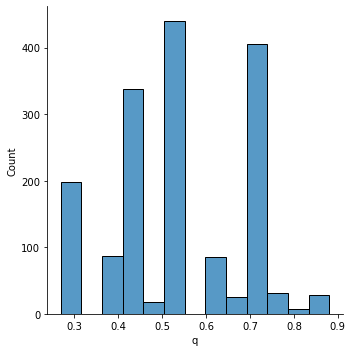

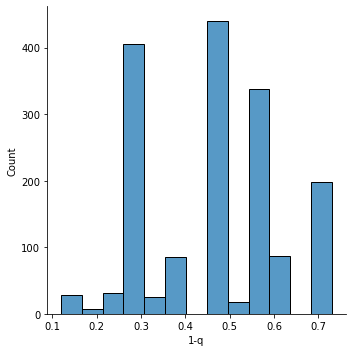

In [36]:
sns.displot(df['q'])
sns.displot(df['1-q']);

In [37]:
df_result = df[['date', 'a', 'cluster_strength']].set_index('date')

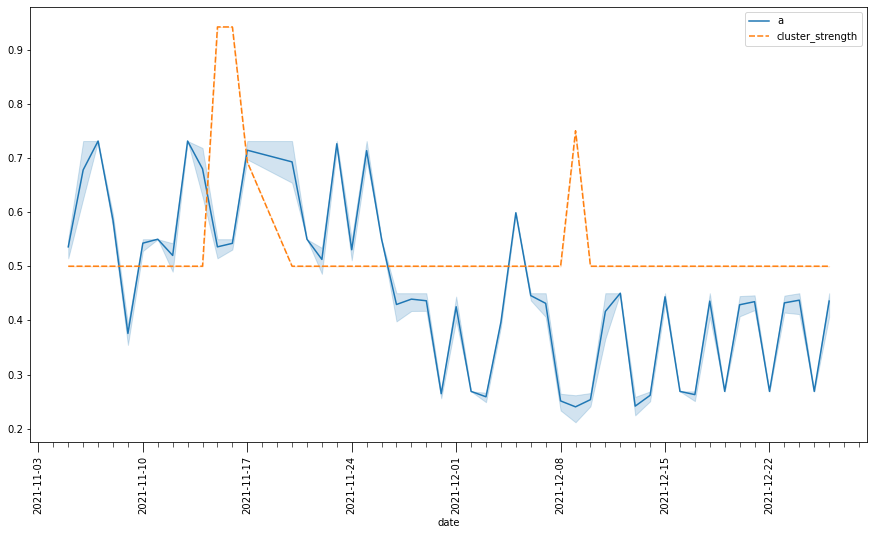

In [38]:
plt.figure(figsize = (15,8))

#ax = sns.lineplot(data=df, x='date', y="1-q")
#ax = sns.lineplot(data=df, x='date', y="q")
ax = sns.lineplot(data=df_result)

# specify the position of the major ticks at the beginning of the week
ax.xaxis.set_major_locator(md.WeekdayLocator(byweekday = 2))

# specify the format of the labels as 'year-month-day'
ax.xaxis.set_major_formatter(md.DateFormatter('%Y-%m-%d'))

# (optional) rotate by 90° the labels in order to improve their spacing
plt.setp(ax.xaxis.get_majorticklabels(), rotation = 90)

# specify the position of the minor ticks at each day
ax.xaxis.set_minor_locator(md.DayLocator(interval = 1))

ax.tick_params(axis = 'x', which = 'major', length = 10)
ax.tick_params(axis = 'x', which = 'minor', length = 5)

#ax.set_title('1-q / Treshold')

plt.show()

<AxesSubplot:xlabel='Date'>

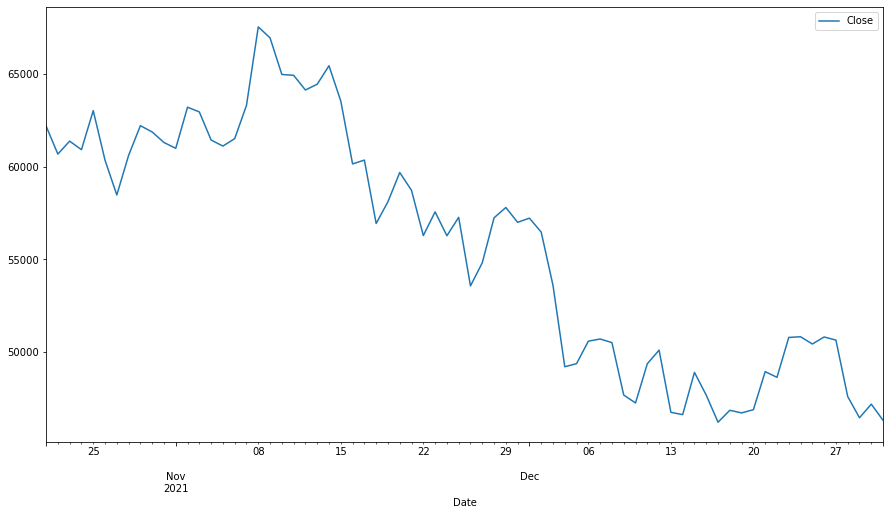

In [39]:
df_ta['Close'].plot(legend=True,figsize=(15,8))